In [ ]:
# Uncomment to install/upgrade ras-commander from pip
#!pip install --upgrade ras-commander

#Import the ras-commander package
from ras_commander import *

##### Optional Code Cell For Development/Testing Mode (Local Copy)
##### Uncomment and run this cell instead of the pip cell above

```python
# For Development Mode, add the parent directory to the Python path
import os
import sys
from pathlib import Path

current_file = Path(os.getcwd()).resolve()
rascmdr_directory = current_file.parent

# Use insert(0) instead of append() to give highest priority to local version
if str(rascmdr_directory) not in sys.path:
    sys.path.insert(0, str(rascmdr_directory))

print("Loading ras-commander from local dev copy")
from ras_commander import *
```

# RAS Commander: RASMapper Operations

This notebook demonstrates how to work with RASMapper configuration files and raster outputs using the `ras-commander` library.

## Workflow

1. **Initialize Project**: Set up the HEC-RAS project and explore the rasmap_df
2. **Generate Stored Maps**: Use `RasMap.postprocess_stored_maps()` to create raster outputs
3. **Locate Results**: Use `RasMap.get_results_folder()` and `RasMap.get_results_raster()` to find outputs
4. **Visualize**: Load and display the generated raster files

## Key Functions

- `RasMap.parse_rasmap()` - Parse .rasmap XML configuration files
- `RasMap.get_terrain_names()` - Extract available terrain layers
- `RasMap.postprocess_stored_maps()` - Automate raster output generation
- `RasMap.get_results_folder()` - Find the output folder for a plan
- `RasMap.get_results_raster()` - Get the path to a specific VRT file

In [1]:
# For Development Mode, add the parent directory to the Python path
import os
import sys
from pathlib import Path

current_file = Path(os.getcwd()).resolve()
rascmdr_directory = current_file.parent

# Use insert(0) instead of append() to give highest priority to local version
if str(rascmdr_directory) not in sys.path:
    sys.path.insert(0, str(rascmdr_directory))
    
print("Loading ras-commander from local dev copy")

# Now try to import
from ras_commander import *

# Verify we're loading from the local copy
import ras_commander
local_path = Path(ras_commander.__file__).parent.parent
print(f"ras-commander loaded from: {local_path}")
print(f"Expected local path: {rascmdr_directory}")
print(f"Successfully using local copy: {local_path == rascmdr_directory}")

Loading ras-commander from local dev copy
ras-commander loaded from: C:\GH\ras-commander
Expected local path: C:\GH\ras-commander
Successfully using local copy: True


In [2]:
# Import additional libraries for visualization
import pandas as pd
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt

## Step 1: Initialize Project and Explore RASMapper Configuration

We'll use the Muncie example project, which is a 2D unsteady flow model. Let's initialize the project and examine the `rasmap_df` dataframe.

In [3]:
# Extract Muncie project if it doesn't exist
project_path = Path("./example_projects/Muncie").resolve()

if not os.path.exists(project_path):
    project_path = RasExamples.extract_project("Muncie")

# Initialize the RAS project with version 6.6
init_ras_project(project_path, "6.6")

print(f"Project initialized: {ras.project_name}")
print(f"Project folder: {ras.project_folder}")
print(f"RAS version: {ras.ras_version}")

2025-11-16 10:31:11 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\example_projects\Muncie\Muncie.rasmap


Project initialized: Muncie
Project folder: C:\GH\ras-commander\examples\example_projects\Muncie
RAS version: 6.6


### Understanding the rasmap_df

The `rasmap_df` dataframe is created during project initialization by parsing the `.rasmap` XML file. It contains all RASMapper configuration information:

- **projection_path**: Coordinate system projection file
- **profile_lines_path**: XS cut lines for extracting profiles
- **soil_layer_path**: Hydrologic soil group layers
- **infiltration_hdf_path**: Infiltration parameter layers
- **landcover_hdf_path**: Land cover classification layers
- **terrain_hdf_path**: Digital elevation model (DEM) layers
- **current_settings**: Various RASMapper display and export settings

This dataframe provides a programmatic way to access all the spatial data layers and configuration used in RASMapper.

In [4]:
# Display the rasmap_df
print("\nRASMapper Configuration DataFrame:")
display(ras.rasmap_df)

# Show what's in each column
print("\n" + "="*60)
print("Column Details:")
print("="*60)

for col in ras.rasmap_df.columns:
    value = ras.rasmap_df[col].iloc[0]
    print(f"\n{col}:")
    if isinstance(value, list):
        if len(value) > 0:
            for item in value:
                print(f"  - {item}")
        else:
            print("  (empty list)")
    elif isinstance(value, dict):
        if len(value) > 0:
            for key, val in value.items():
                print(f"  {key}: {val}")
        else:
            print("  (empty dict)")
    else:
        print(f"  {value}")


RASMapper Configuration DataFrame:


,projection_path,profile_lines_path,soil_layer_path,infiltration_hdf_path,landcover_hdf_path,terrain_hdf_path,current_settings
0,C:\GH\ras-commander\examples\example_projects\...,[C:\GH\ras-commander\examples\example_projects...,[],[],[],[C:\GH\ras-commander\examples\example_projects...,"{'RiverStationUnits': 'Feet', 'RiverStationDec..."



Column Details:

projection_path:
  C:\GH\ras-commander\examples\example_projects\Muncie\GIS_Data\Muncie_IA_Clip.prj

profile_lines_path:
  - C:\GH\ras-commander\examples\example_projects\Muncie\Features\Profile Lines.shp

soil_layer_path:
  (empty list)

infiltration_hdf_path:
  (empty list)

landcover_hdf_path:
  (empty list)

terrain_hdf_path:
  - C:\GH\ras-commander\examples\example_projects\Muncie\Terrain\Terrain.hdf

current_settings:
  RiverStationUnits: Feet
  RiverStationDecimalPlaces: 0
  HorizontalDecimalPlaces: 1
  VerticalDecimalPlaces: 2
  XSMaxPoints: 450
  LSMaxPoints: 1000
  ProfilePointMinCount: 0
  ShowLegend: True
  ShowNorthArrow: False
  ShowScaleBar: True
  ShowGreaterThanInLegend: False
  TerrainDestinationFolder: .\Terrain
  AddDataFolder: .\LandCover
  LandCoverDestinationFolder: ..\Muncie
  TerrainSourceFolder: .\Terrain


### Get Available Terrains

Before generating stored maps, we need to know which terrain layers are available. The `get_terrain_names()` function extracts this from the .rasmap file.

In [5]:
# Get the rasmap file path
rasmap_path = ras.project_folder / f"{ras.project_name}.rasmap"

# Extract terrain names
terrains = RasMap.get_terrain_names(rasmap_path)
print(f"Available terrains: {terrains}")

# Select the first terrain for our mapping
target_terrain = None
if terrains:
    target_terrain = terrains[0]
    print(f"\nUsing terrain: {target_terrain}")

2025-11-16 10:31:11 - ras_commander.RasMap - INFO - Extracted terrain names: ['Terrain']


Available terrains: ['Terrain']

Using terrain: Terrain


## Step 2: Check for Existing Results

Let's examine what plans are available and whether they have been computed.

In [6]:
ras.plan_df

,plan_number,unsteady_number,geometry_number,Plan Title,Program Version,Short Identifier,Simulation Date,Computation Interval,Mapping Interval,Run HTab,...,Friction Slope Method,UNET D2 SolverType,UNET D2 Name,HDF_Results_Path,Geom File,Geom Path,Flow File,Flow Path,full_path,flow_type
0,01,01,01,Unsteady Multi 9-SA run,5.00,9-SAs,"02JAN1900,0000,02JAN1900,2400",15SEC,5MIN,0,...,1,NaN,NaN,C:\GH\ras-commander\examples\example_projects\...,01,C:\GH\ras-commander\examples\example_projects\...,01,C:\GH\ras-commander\examples\example_projects\...,C:\GH\ras-commander\examples\example_projects\...,Unsteady
1,03,01,02,Unsteady Run with 2D 50ft Grid,5.10,2D 50ft Grid,"02JAN1900,0000,02JAN1900,2400",10SEC,5MIN,-1,...,1,Pardiso (Direct),2D Interior Area,None,02,C:\GH\ras-commander\examples\example_projects\...,01,C:\GH\ras-commander\examples\example_projects\...,C:\GH\ras-commander\examples\example_projects\...,Unsteady
2,04,01,04,Unsteady Run with 2D 50ft User n Value R,5.10,50ft User n Regions,"02JAN1900,0000,02JAN1900,2400",10SEC,5MIN,1,...,1,Pardiso (Direct),2D Interior Area,None,04,C:\GH\ras-commander\examples\example_projects\...,01,C:\GH\ras-commander\examples\example_projects\...,C:\GH\ras-commander\examples\example_projects\...,Unsteady


In [7]:
# Step 2: Check for Existing Results and Display Status by Plan

# Show which plans exist and which have results HDF files present.
import pandas as pd

# Choose relevant columns for clarity
plan_results_cols = ['plan_number', 'Short Identifier', 'HDF_Results_Path']
plan_results_df = ras.plan_df[plan_results_cols]

print("Available plans and HDF results status:")
plan_results_df

Available plans and HDF results status:


,plan_number,Short Identifier,HDF_Results_Path
0,01,9-SAs,C:\GH\ras-commander\examples\example_projects\...
1,03,2D 50ft Grid,None
2,04,50ft User n Regions,None


In [8]:
# We'll select a plan to work with (using plan number "01")
plan_number = "01"

# Check for the computed HDF results file (outputs typically end with .pXX.hdf)
plan_hdf_path = ras.project_folder / f"{ras.project_name}.p{plan_number}.hdf"

if plan_hdf_path.exists():
    print(f"\nResults for plan {plan_number} are already present at:\n  {plan_hdf_path}")
else:
    print(f"\nResults for plan {plan_number} not found. Running the simulation now...")
    # Run the plan using RasCmdr.compute_plan; ensure appropriate number of cores if large/2D
    success = RasCmdr.compute_plan(plan_number, num_cores=4)
    if not success:
        raise RuntimeError(f"Computation of plan {plan_number} failed.")
    print(f"Plan {plan_number} successfully computed. Results should now be available at:\n  {plan_hdf_path}")


Results for plan 01 are already present at:
  C:\GH\ras-commander\examples\example_projects\Muncie\Muncie.p01.hdf


## Step 3: Generate Stored Maps Using postprocess_stored_maps()

The `postprocess_stored_maps()` function automates the process of creating raster outputs:

1. Backs up the original plan and .rasmap files
2. Modifies plan flags to only run floodplain mapping (not the full simulation)
3. Adds stored map definitions to the .rasmap file
4. Opens HEC-RAS for you to run the plan
5. Restores original files after completion

**Note:** HEC-RAS 6.x requires the GUI to be open for floodplain mapping. The function will open HEC-RAS and wait for you to close it.

In [9]:
# Generate stored maps for WSE, Depth, and Velocity
print("Generating stored maps for WSE, Depth, and Velocity...")
print("\nHEC-RAS will open. Please:")
print("1. Click 'Compute' (or use Run > Unsteady Flow Analysis)")
print("2. Wait for the floodplain mapping to complete")
print("3. Close HEC-RAS when finished")
print("\nThe script will continue automatically after you close HEC-RAS.")

success = RasMap.postprocess_stored_maps(
    plan_number=plan_number,
    specify_terrain=target_terrain,
    layers=['WSE', 'Depth', 'Velocity']  # Generate all three variables
)

if success:
    print("\n" + "="*60)
    print("Successfully generated stored maps!")
    print("="*60)
else:
    print("\nFailed to generate stored maps.")

2025-11-16 10:31:11 - ras_commander.RasMap - INFO - Backing up plan file C:\GH\ras-commander\examples\example_projects\Muncie\Muncie.p01 to C:\GH\ras-commander\examples\example_projects\Muncie\Muncie.p01.storedmap.bak
2025-11-16 10:31:11 - ras_commander.RasMap - INFO - Updating plan run flags for floodplain mapping for plan 01...
2025-11-16 10:31:11 - ras_commander.RasPlan - INFO - Successfully updated run flags in plan file: C:\GH\ras-commander\examples\example_projects\Muncie\Muncie.p01
2025-11-16 10:31:11 - ras_commander.RasMap - INFO - Backing up rasmap file C:\GH\ras-commander\examples\example_projects\Muncie\Muncie.rasmap to C:\GH\ras-commander\examples\example_projects\Muncie\Muncie.rasmap.storedmap.bak
2025-11-16 10:31:11 - ras_commander.RasMap - INFO - Added 'WSE' stored map to results layer for plan 01.
2025-11-16 10:31:11 - ras_commander.RasMap - INFO - Added 'Depth' stored map to results layer for plan 01.
2025-11-16 10:31:11 - ras_commander.RasMap - INFO - Added 'Velocity'

Generating stored maps for WSE, Depth, and Velocity...

HEC-RAS will open. Please:
1. Click 'Compute' (or use Run > Unsteady Flow Analysis)
2. Wait for the floodplain mapping to complete
3. Close HEC-RAS when finished

The script will continue automatically after you close HEC-RAS.


2025-11-16 10:31:11 - ras_commander.RasGuiAutomation - INFO - Waiting for HEC-RAS main window...
2025-11-16 10:31:14 - ras_commander.RasGuiAutomation - INFO - Found HEC-RAS main window: HEC-RAS 6.6
2025-11-16 10:31:14 - ras_commander.RasGuiAutomation - INFO - Clicking 'Run > Unsteady Flow Analysis' menu...
2025-11-16 10:31:15 - ras_commander.RasGuiAutomation - INFO - Clicked menu item ID: 47
2025-11-16 10:31:17 - ras_commander.RasGuiAutomation - INFO - Looking for Unsteady Flow Analysis dialog...
2025-11-16 10:31:17 - ras_commander.RasGuiAutomation - INFO - Found Unsteady Flow Analysis dialog
2025-11-16 10:31:17 - ras_commander.RasGuiAutomation - INFO - Looking for Compute button...
2025-11-16 10:31:17 - ras_commander.RasGuiAutomation - WARNING - Could not find Compute button - user must click manually
2025-11-16 10:31:17 - ras_commander.RasGuiAutomation - INFO - Trying keyboard shortcut as fallback...
2025-11-16 10:31:18 - ras_commander.RasGuiAutomation - INFO - Sent Enter key to dial


Successfully generated stored maps!


## Step 4: Locate Results Using get_results_folder() and get_results_raster()

Now that we've generated the raster outputs, we can use the new functions to locate them programmatically.

### Understanding the Output Folder Structure

HEC-RAS creates output folders based on the plan's **Short Identifier**. Windows folder naming replaces special characters (like `/`, `\`, `:`, `*`, `?`, `"`, `<`, `>`, `|`, `+`, ` `) with underscores (`_`).

The `get_results_folder()` function handles this normalization automatically and finds the correct folder.

In [10]:
# Get the results folder for this plan
results_folder = RasMap.get_results_folder(plan_number)
print(f"Results folder: {results_folder}")

# List all files in the results folder
print("\nFiles in results folder:")
for file in sorted(results_folder.iterdir()):
    print(f"  - {file.name}")

2025-11-16 10:34:27 - ras_commander.RasMap - INFO - Found output folder (exact match): C:\GH\ras-commander\examples\example_projects\Muncie\9-SAs


Results folder: C:\GH\ras-commander\examples\example_projects\Muncie\9-SAs

Files in results folder:
  - Depth (Max).Terrain.muncie_clip.tif
  - Depth (Max).vrt
  - PostProcessing.hdf
  - Velocity (Max).Terrain.muncie_clip.tif
  - Velocity (Max).vrt
  - WSE (Max).Terrain.muncie_clip.tif
  - WSE (Max).vrt


### Get Specific Raster Files

The `get_results_raster()` function searches for VRT files matching a variable name. VRT (Virtual Raster) files are lightweight files that reference the underlying TIFF tiles.

The function performs a **case-insensitive substring match**, so:
- `"WSE"` will match `"WSE (Max).vrt"` or `"WSE (10Pct).vrt"`
- `"WSE (Max)"` will match only `"WSE (Max).vrt"`

If multiple files match, it will raise an error and show you all matching files so you can be more specific.

In [11]:
# Get specific raster files
wse_vrt = RasMap.get_results_raster(plan_number, "WSE (Max)")
depth_vrt = RasMap.get_results_raster(plan_number, "Depth (Max)")
velocity_vrt = RasMap.get_results_raster(plan_number, "Velocity (Max)")

print("Found raster files:")
print(f"  WSE:      {wse_vrt.name}")
print(f"  Depth:    {depth_vrt.name}")
print(f"  Velocity: {velocity_vrt.name}")

2025-11-16 10:34:27 - ras_commander.RasMap - INFO - Found output folder (exact match): C:\GH\ras-commander\examples\example_projects\Muncie\9-SAs
2025-11-16 10:34:27 - ras_commander.RasMap - INFO - Found matching VRT file: C:\GH\ras-commander\examples\example_projects\Muncie\9-SAs\WSE (Max).vrt
2025-11-16 10:34:27 - ras_commander.RasMap - INFO - Found output folder (exact match): C:\GH\ras-commander\examples\example_projects\Muncie\9-SAs
2025-11-16 10:34:27 - ras_commander.RasMap - INFO - Found matching VRT file: C:\GH\ras-commander\examples\example_projects\Muncie\9-SAs\Depth (Max).vrt
2025-11-16 10:34:27 - ras_commander.RasMap - INFO - Found output folder (exact match): C:\GH\ras-commander\examples\example_projects\Muncie\9-SAs
2025-11-16 10:34:27 - ras_commander.RasMap - INFO - Found matching VRT file: C:\GH\ras-commander\examples\example_projects\Muncie\9-SAs\Velocity (Max).vrt


Found raster files:
  WSE:      WSE (Max).vrt
  Depth:    Depth (Max).vrt
  Velocity: Velocity (Max).vrt


### Demonstrating Flexible Plan Number Handling

Both functions accept plan numbers in multiple formats for convenience.

In [12]:
# All of these work the same way:
folder1 = RasMap.get_results_folder(1)          # Integer
folder2 = RasMap.get_results_folder("01")       # Two-digit string
folder3 = RasMap.get_results_folder("001")      # Three-digit string

print("Flexible plan number handling:")
print(f"  get_results_folder(1)     -> {folder1 == results_folder}")
print(f"  get_results_folder('01')  -> {folder2 == results_folder}")
print(f"  get_results_folder('001') -> {folder3 == results_folder}")

2025-11-16 10:34:27 - ras_commander.RasMap - INFO - Found output folder (exact match): C:\GH\ras-commander\examples\example_projects\Muncie\9-SAs
2025-11-16 10:34:27 - ras_commander.RasMap - INFO - Found output folder (exact match): C:\GH\ras-commander\examples\example_projects\Muncie\9-SAs
2025-11-16 10:34:27 - ras_commander.RasMap - INFO - Found output folder (exact match): C:\GH\ras-commander\examples\example_projects\Muncie\9-SAs


Flexible plan number handling:
  get_results_folder(1)     -> True
  get_results_folder('01')  -> True
  get_results_folder('001') -> True


## Step 5: Visualize the Results

Now let's load and visualize the raster files we've located.

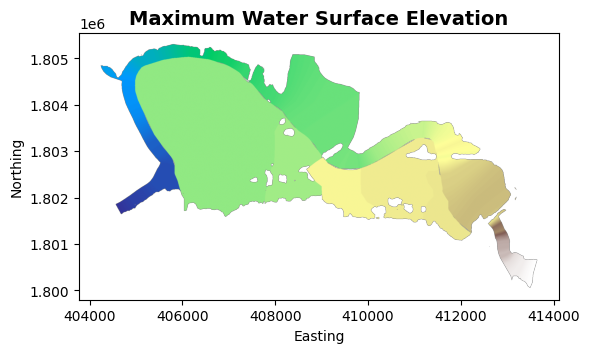

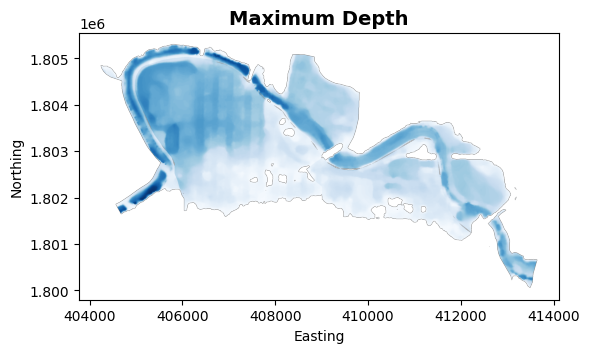

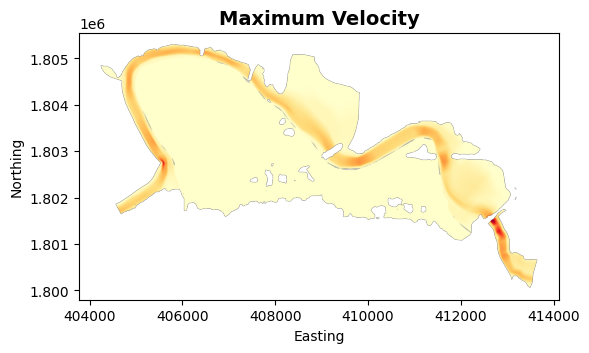

In [13]:
import matplotlib.pyplot as plt
import rasterio
import numpy as np

def get_valid_data_bounds(src) -> tuple:
    """
    Returns the bounding box of valid (non-nodata) values in raster coordinates,
    expanded by 10% on all sides and transformed to spatial coordinates.
    """
    data = src.read(1, masked=True)
    # Find where data is not nodata
    valid_mask = np.ma.getmaskarray(data) == 0
    rows, cols = np.where(valid_mask)
    if rows.size == 0 or cols.size == 0:
        # No data found, fallback to raster extents
        bounds = src.bounds
        return bounds.left, bounds.right, bounds.bottom, bounds.top

    # Find min/max in pixel coordinates
    row_min, row_max = rows.min(), rows.max()
    col_min, col_max = cols.min(), cols.max()

    # Transform corners to map coordinates
    top_left = src.transform * (col_min, row_min)
    bottom_right = src.transform * (col_max + 1, row_max + 1)  # +1 to include the edge

    xmin = top_left[0]
    ymax = top_left[1]
    xmax = bottom_right[0]
    ymin = bottom_right[1]

    # Expand bounds by 10%
    width = xmax - xmin
    height = ymax - ymin
    xpad = width * 0.10 / 2.0
    ypad = height * 0.10 / 2.0

    return (
        xmin - xpad,
        xmax + xpad,
        ymin - ypad,
        ymax + ypad
    )


def plot_raster_with_valid_bounds(raster_path, cmap, title):
    with rasterio.open(raster_path) as src:
        valid_bounds = get_valid_data_bounds(src)
        fig, ax = plt.subplots(figsize=(6, 6))
        img = ax.imshow(
            src.read(1, masked=True),
            cmap=cmap,
            extent=[src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top],
            origin='upper'
        )
        ax.set_xlim(valid_bounds[0], valid_bounds[1])
        ax.set_ylim(valid_bounds[2], valid_bounds[3])
        ax.set_xlabel('Easting')
        ax.set_ylabel('Northing')
        ax.set_title(title, fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.show()


# Plot WSE individually (zoom to actual data mask)
plot_raster_with_valid_bounds(
    wse_vrt, cmap='terrain', title='Maximum Water Surface Elevation'
)

# Plot Depth individually (zoom to actual data mask)
plot_raster_with_valid_bounds(
    depth_vrt, cmap='Blues', title='Maximum Depth'
)

# Plot Velocity individually (zoom to actual data mask)
plot_raster_with_valid_bounds(
    velocity_vrt, cmap='YlOrRd', title='Maximum Velocity'
)

### Get Raster Metadata

We can use rasterio to examine the raster properties.

In [14]:
# Examine depth raster properties
with rasterio.open(depth_vrt) as src:
    print("Depth Raster Metadata:")
    print(f"  CRS:        {src.crs}")
    print(f"  Dimensions: {src.width} x {src.height}")
    print(f"  Resolution: {src.res}")
    print(f"  Bounds:     {src.bounds}")
    print(f"  NoData:     {src.nodata}")
    print(f"  Data Type:  {src.dtypes[0]}")

Depth Raster Metadata:
  CRS:        PROJCS["NAD83 / Indiana East (ftUS)",GEOGCS["NAD83",DATUM["North_American_Datum_1983",SPHEROID["GRS 1980",6378137,298.257222101004,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6269"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4269"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",37.5],PARAMETER["central_meridian",-85.6666666666667],PARAMETER["scale_factor",0.999966666666667],PARAMETER["false_easting",328083.333333333],PARAMETER["false_northing",820208.333333333],UNIT["US survey foot",0.304800609601219,AUTHORITY["EPSG","9003"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]
  Dimensions: 7892 x 4538
  Resolution: (5.0, 5.0)
  Bounds:     BoundingBox(left=384977.84867792, bottom=1788863.5402636, right=424437.84867792, top=1811553.5402636)
  NoData:     -9999.0
  Data Type:  float32


## Step 6: Working with Multiple Plans

The `get_results_folder()` and `get_results_raster()` functions make it easy to work with multiple plans programmatically.

In [15]:
# Get results for all computed plans
print("Results folders for all plans:")
print("="*60)

for idx, row in ras.plan_df.iterrows():
    plan_num = row['plan_number']
    short_id = row['Short Identifier']
    
    # Check if HDF results exist
    hdf_path = ras.project_folder / f"{ras.project_name}.p{plan_num}.hdf"
    if hdf_path.exists():
        try:
            folder = RasMap.get_results_folder(plan_num)
            print(f"Plan {plan_num} ({short_id}):")
            print(f"  Folder: {folder.name}")
            
            # Count VRT files
            vrt_files = list(folder.glob("*.vrt"))
            print(f"  VRT files: {len(vrt_files)}")
            for vrt in vrt_files:
                print(f"    - {vrt.name}")
            print()
        except ValueError as e:
            print(f"Plan {plan_num} ({short_id}): No results folder (likely no stored maps)")
            print()
    else:
        print(f"Plan {plan_num} ({short_id}): Not computed")
        print()

2025-11-16 10:34:40 - ras_commander.RasMap - INFO - Found output folder (exact match): C:\GH\ras-commander\examples\example_projects\Muncie\9-SAs


Results folders for all plans:
Plan 01 (9-SAs):
  Folder: 9-SAs
  VRT files: 3
    - Depth (Max).vrt
    - Velocity (Max).vrt
    - WSE (Max).vrt

Plan 03 (2D 50ft Grid): Not computed

Plan 04 (50ft User n Regions): Not computed



## Summary

This notebook demonstrated the complete RASMapper workflow:

1. **Project Initialization**: Loaded project and examined `rasmap_df` configuration
2. **Terrain Discovery**: Used `get_terrain_names()` to find available DEMs
3. **Stored Map Generation**: Used `postprocess_stored_maps()` to create WSE, Depth, and Velocity rasters
4. **Results Location**: Used `get_results_folder()` and `get_results_raster()` to find outputs
5. **Visualization**: Loaded and displayed raster files with rasterio

### Key Takeaways

- The `rasmap_df` provides programmatic access to all RASMapper configuration
- `postprocess_stored_maps()` automates the tedious process of generating raster outputs
- `get_results_folder()` handles Windows folder naming normalization automatically
- `get_results_raster()` provides smart matching for finding specific variable outputs
- Both functions accept flexible plan number formats (1, "01", "001")
- VRT files are lightweight references to underlying TIFF tiles

These functions significantly streamline workflows involving raster output generation and processing for multiple plans or scenarios.